# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Vorbereitung**

In [10]:
# import libraries
from uuid import uuid4
import os
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

import src.data_loader as dl
import src.visualization as vis
import src.net_models as net
import src.input_preparation as ip

In [11]:
# set the source directory for the preprocessed data to use
SOURCE: str = "f2fcf2aa-bd96-4d89-8bb5-4a0a1bc11b1b"

# setup a single index for control purposes
CONTROL_INDEX: int = 0

# generate a unique identifier for this run
UUID: str = str(uuid4())
print(f"Current UUID:\t{UUID}")

Current UUID:	5b0acd8b-e48e-4614-a786-000befea0efb


In [12]:
# setup system and check the number of cpu cores and gpus available
net.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

Üblicherweise werden für das Training eines neuronalen Netzes mittels Supervised Learning die Daten in mindestens zwei separate Datensätze aufgeteilt: einen Trainings- und einen Testdatensatz. Mit dem Testdatensatz können nach dem Training zukünftige (dem Netz unbekannte) Dateneingaben simuliert werden und so vorab die Zuverlässigkeit des Trainings beurteilt werden (Liu, 2025, S. 39).
Nach dem Laden der Daten aus dem *data*-Ordner werden CSV-Dateien mit der Endung *D* in der Liste *development_data* und Dateien mit der Endung *E* in der Liste *evaluation_data* gespeichert.

In [13]:
# load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "processed" / SOURCE
development_data, evaluation_data = dl.load_all_datasets(data_path)

# define file path for metrics and confusion matrix
figure_path = Path().cwd() / "results" / "metrics" / ("m_" + UUID)

load_all_datasets():
	Reading development data ...
	0D_0_fft.csv successfully loaded.
	0D_1_fft.csv successfully loaded.
	1D_0_fft.csv successfully loaded.
	1D_1_fft.csv successfully loaded.
	2D_0_fft.csv successfully loaded.
	2D_1_fft.csv successfully loaded.
	3D_0_fft.csv successfully loaded.
	3D_1_fft.csv successfully loaded.
	4D_0_fft.csv successfully loaded.
	4D_1_fft.csv successfully loaded.
	Reading evaluation data ...
	0E_0_fft.csv successfully loaded.
	0E_1_fft.csv successfully loaded.
	1E_0_fft.csv successfully loaded.
	1E_1_fft.csv successfully loaded.
	2E_0_fft.csv successfully loaded.
	2E_1_fft.csv successfully loaded.
	3E_0_fft.csv successfully loaded.
	3E_1_fft.csv successfully loaded.
	4E_0_fft.csv successfully loaded.
	4E_1_fft.csv successfully loaded.
	Reading completed.



Exemplarisch wird ein Datensatz aus den Development-Daten in mehreren Subplots visualisiert, um sicherzustellen, dass die Daten korrekt geladen wurden. 

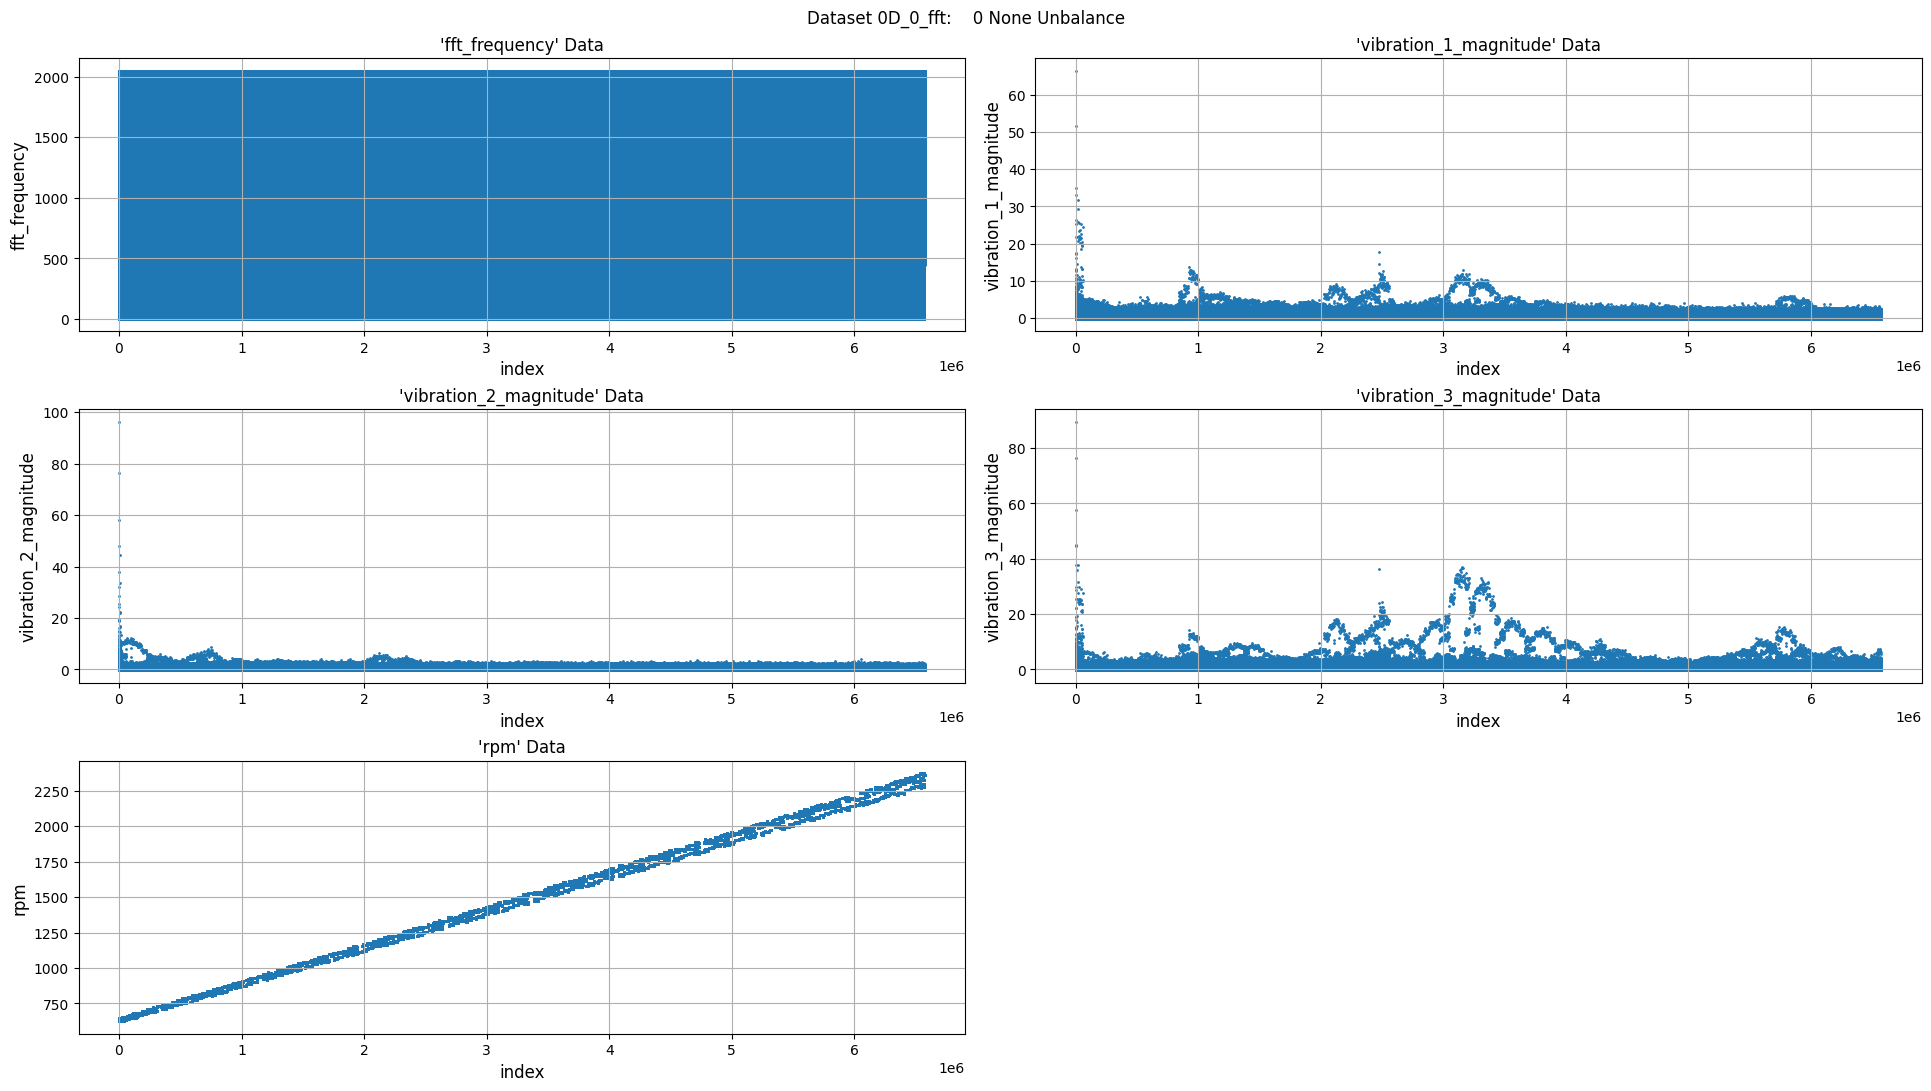

[{'figure': <Figure size 1920x1080 with 5 Axes>,
  'file_name': '0D_0_fft_fft_frequency_vibration_1_magnitude_vibration_2_magnitude_vibration_3_magnitude_rpm'}]

In [14]:
# visualize one random dataset for data validation
vis.plot_column_data(development_data[CONTROL_INDEX],
                             development_data[CONTROL_INDEX].columns)

#### **Vorbereitung der Daten zur Eingabe in das neuronale Netz**

Um das neuronale Netz trainieren zu können, ist eine Aufbereitung der Trainings- und Testdaten erforderlich.
Dazu werden die einzelnen DataFrames mit den Trainingsdaten zu einem einheitlichen DataFrame zusammengeführt. Gleichzeitig wird eine zusätzliche Spalte *Label* erstellt, welche die gemessenen Unwuchtstärken (*none*, *slight*, *moderate*, *significant* und *strong*) enthält und somit als *Output* für die spätere Klassifizierung dient (Liu, 2025, S.19). Die Labels werden in das One-Hot-Encoding-Format überführt, welches für die Multiklassen-Klassifizierung in Deep-Learning-Systemen benötigt wird (Liu, 2025, S.74).
Anschließend werden die DataFrame-Spalten mit den Amplituden der Vibrationen als *Input* (Features) für das NN spezifiziert.

In [15]:
full_development_dataset = ip.concatenate_datasets(development_data)

training_samples_dict = ip.split_data(
    dataframe=full_development_dataset,
    data_columns=[
        "vibration_1_magnitude",
        # "vibration_2_magnitude",
        # "vibration_3_magnitude",
    ],
)

print(training_samples_dict["labels"].shape)
print(training_samples_dict["samples"].shape)

(32131, 5)
(32131, 2048)


Mit dem Aufruf der Funktion `check_data` werden die im vorbereiteten Datensatz enthaltenen Klassen sowie deren jeweilige Häufigkeiten überprüft, um einen Überblick über die Verteilung der verschiedenen Labels im Trainingsdatensatz zu gewinnen. Es ist wichtig eine ausgewogene Klassen-Verteilung sicherzustellen, da eine ungleiche Verteilung zu Bias und damit zu ungenauen Vorhersagen führen kann (Liu, 2025, S.36).
Die Ausgabe von `check_data` zeigt, dass alle fünf Klassen in etwa 6430 Einträge umfassen und somit einen ausgeglichenen Querschnitt der Trainingsdaten abbilden. 

In [16]:
ip.check_data(training_samples_dict)


check_data():
	Class '0 none':	6428.0 samples
	Class '1 slight':	6425.0 samples
	Class '2 moderat':	6428.0 samples
	Class '3 significant':	6425.0 samples
	Class '4 strong':	6425.0 samples


#### **Das Neuronale Netz**

Im nachfolgenden Codeabschnitt werden alle relevanten Parameter und Hyperparameter, die für den Aufbau und das Training des NN benötigt werden, zentral definiert. Durch die Zusammenfassung an einer Stelle bleibt der Code übersichtlicher und Anpassungen am Lernverhalten des Modells können schnell vorgenommen werden.

Die Konstanten sind nach ihrer Zuständigkeit in separate Abschnitte zur Modellerstellung, Modellkompilierung und zum Training des Modells gegliedert. Abschließend werden in dem Dictionary `training_samples_dict` Gewichtungen auf die Unwuchtklassen individuell eingestellt. Diese Gewichtungen können genutzt werden, wenn einzelne Klassen im Datensatz unterrepräsentiert sind oder vom Modell schlechter erkannt werden, um für eine ausgewogenere Vorhersageleistung zu sorgen.

In [17]:
# model creation parameters
N_HIDDEN_LAYERS: int = 4
L2: float = 1e-3 # 0.001
DROPOUT: float = 0.3
NEGATIVE_SLOPE: float = 0.3

# model compilation parameters
LEARNING_RATE: float = 1e-4

# model training parameters
BATCH_SIZE: int = 64
EPOCHS: int = 1
VALIDATION_SPLIT: float = 0.1

# manual changes to class weights
training_samples_dict["class_weights"] = {
    0: 0.7,  # none (Klasse 0) wird weniger stark gewichtet
    1: 2.5,  # slight (Klasse 1) wird stärker gewichtet
    2: 1.5,  # moderate (Klasse 2) wird leicht erhöht
    3: 1.2,  # significant (Klasse 3) wird leicht erhöht
    4: 0.7   # strong (Klasse 4) wird weniger stark gewichtet
}

In der Funktion `construct_fft_net_model` wird die *Keras Sequential API* eingesetzt, um ein NN als linearen Stapel von Layern zu definieren (Keras, o.D.-c). Hierfür wird eine Instanz der Klasse Sequential erzeugt und mit Input-, Output- sowie der zuvor spezifizierten Anzahl Hidden Layers erweitert.

Je nach Eingabeformat der Daten (1D-Struktur oder sequentielle Daten), wird dynamisch entschieden, ob eine *Fully Connected* oder eine *Convolutional* Netzwerkarchitektur erstellt wird. Analog zu Mey et al. umfasst das erste Dense-Layer 2048 Neuronen. In diesem Projekt ist dieses Layer um eine *L2-Regularisierung* sowie ein *Dropout* ergänzt, um Overfitting vorzubeugen (vgl. Liu, 2025, S.40f & 194).

Als Aktivierungsfunktion kommt eine *LeakyReLU* mit einstellbarem *negative_slope* zum Einsatz, um das sogenannte *dying ReLU*‑Problem, also die langfristige Deaktivierung einzelner Neuronen, zu vermeiden (Adari & Alla, 2024, S.200). Abschließend wird im Output-Layer eine *Softmax*-Aktivierungsfunktion genutzt, um damit das Modell auf eine Multiklassen-Klassifikation anzupassen. Die Softmax-Funktion wird für Klassifikationsaufgaben verwendet, bei denen eine spezifische Klasse aus dem Input vorhergesagt werden soll (Adari & Alla, 2024, S.203).

In [18]:
model = net.multiclass_classifier.build_model(
    n_hidden_layers=N_HIDDEN_LAYERS,
    training_samples_dict=training_samples_dict,
    l2=L2,
    dropout=DROPOUT,
    negative_slope=NEGATIVE_SLOPE,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,448,453 (36.04 MB)

 Trainable params: 9,448,453 (36.04 MB)

 Non-trainable params: 0 (0.00 B)

Im anschließenden Schritt wird das zuvor definierte Modell mithilfe der Funktion `compile` für das Training vorbereitet. Über den Parameter `learning_rate` wird festgelegt, wie stark die Gewichte des Netzes bei jedem Update angepasst werden (vgl. Adari & Alla, 2024, S.216).


In [19]:
net.multiclass_classifier.compile(model=model, learning_rate=LEARNING_RATE)

Das Training des Modells wird mit der Funktion `train` aufgerufen. Dabei werden die Trainingsdaten aus dem *samples_dict*, die maximale Epochenanzahl, die *Batch-Size* und der *Validation-Split* als Parameter übergeben. Zusätzlich kann ein *Early Stopping*-Mechanismus konfiguriert werden. 

Early Stopping überwacht die Validierungsverluste und beendet das Training vorzeitig, wenn sich der Verlust über mehrere Epochen nicht mehr verbessert. Somit muss das Training bei suboptimal getroffenen Einstellungen des NNs nicht vollständig durchlaufen und wird vorzeitig abgebrochen. Das spart Rechenleistung und kann Overfitting vermeiden (vgl. Adari & Alla, 2024, S.225). Die Implementierung erfolgt über den EarlyStopping-Callback von Keras (Keras, o.D.-a). In der Funktion `train` ist EarlyStopping standardmäßig aktiviert, kann jedoch über den Parameter `use_early_stopping` bei Bedarf deaktiviert werden.

Das Training selbst wird über die übergebene Anzahl von Epochen mit der Methode `model.fit` durchgeführt (Keras, o.D.-b). Der Parameter `shuffle=True` sorgt dafür, dass die Trainingsdaten vor jeder Epoche durchmischt werden, wodurch das Modell unabhängiger von der Reihenfolge der Daten wird. Mit dem Parameter `class_weight` können die Gewichtungen der einzelnen Klassen gesetzt werden, um das Training bei unausgeglichenen Datensätzen zu verbessern (Keras, o.D.-b).

Am Ende gibt die Funktion ein *keras.callbacks.History*-Objekt zurück. Dieses Objekt speichert Metriken wie *Loss*, *Accuracy*, *Precision* und *Recall* über den Trainingsverlauf.


In [20]:
history = net.train(
    model=model,
    samples_dict=training_samples_dict,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    use_early_stopping=True,
)

452/452 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.8142 - f1_score: 0.8068 - loss: 4.7252 - precision: 0.8976 - recall: 0.7529 - val_accuracy: 0.9950 - val_f1_score: 0.9951 - val_loss: 3.4947 - val_precision: 0.9950 - val_recall: 0.9950


#### **Bewertung des Neuronalen Netzes**

Im Anschluss an das Training werden die Daten aus dem History-Objekt visualisiert. Die Funktion `plot_training_history` ermöglicht es, den Verlauf von Metriken über die Trainingsepochen hinweg grafisch darzustellen.
Anhand der Loss Kurven von Trainings- und Validierungs-Daten lässt sich überprüfen, ob das Modell Overfitting-Verhalten aufweist. Gemäß Adari und Alla liegt ein typischer Overfitting-Fall vor, wenn das Trainings-Loss kontinuierlich sinkt, während das Validierungs-Loss ab einer gewissen Epoche beginnt zu steigen (2024, S.225). Idealerweise sollten sich beide Kurven gleichermaßen einem geringen Wert annähern. Nach dem Training mit 20 Epochen, nähert sich das Training-Loss dem Wert 0.2 und das Validation-Loss dem Wert 0.03 an. Die zwei Kurven liegen dicht beieinander und somit weist das Training kein Overfitting-Verhalten auf.

Bezüglich Accuracy verweisen Adari und Alla darauf, dass diese zwar eine erste Aussage über die Prognosefähigkeit des Modells liefert (2024, S. 107), jedoch in vielen Fällen – insbesondere bei Klassifikationsaufgaben – nicht ausreichend aussagekräftig ist (2024, S.115). Deshalb empfiehlt Liu Precision und Recall in die Modellevaluation miteinzubeziehen (2025, S.300).
Precision gibt den prozentualen Anteil korrekter Positivvorhersagen am Gesamtvolumen an, während Recall den Prozentsatz tatsächlich erkannter Positiver innerhalb aller Positiven beschreibt (Adari & Alla, 2024, S.116).

Adari und Alla definieren die F1-Metrik als harmonischen Mittelwert von Precision und Recall, bei dem ein höherer Wert darauf hinweist, dass beide Größen vergleichsweise hoch sind (2024, S. 116). Liu beschreibt, dass ein steigender F1-Wert auf eine höhere Prognosekraft des Modells schließen lässt: Ein Wert nahe 1 deutet auf ein nahezu perfektes Klassifikationsmodell hin, während ein F1-Wert nahe 0 auf eine sehr geringe Vorhersagefähigkeit schließen lässt (2025, S. 414). Mit dem Modell dieses Projektes wird nach 20 Epochen sowohl eine Accuracy als auch ein F1-Wert von nahezu 100% mit den Trainingsdaten erreicht.

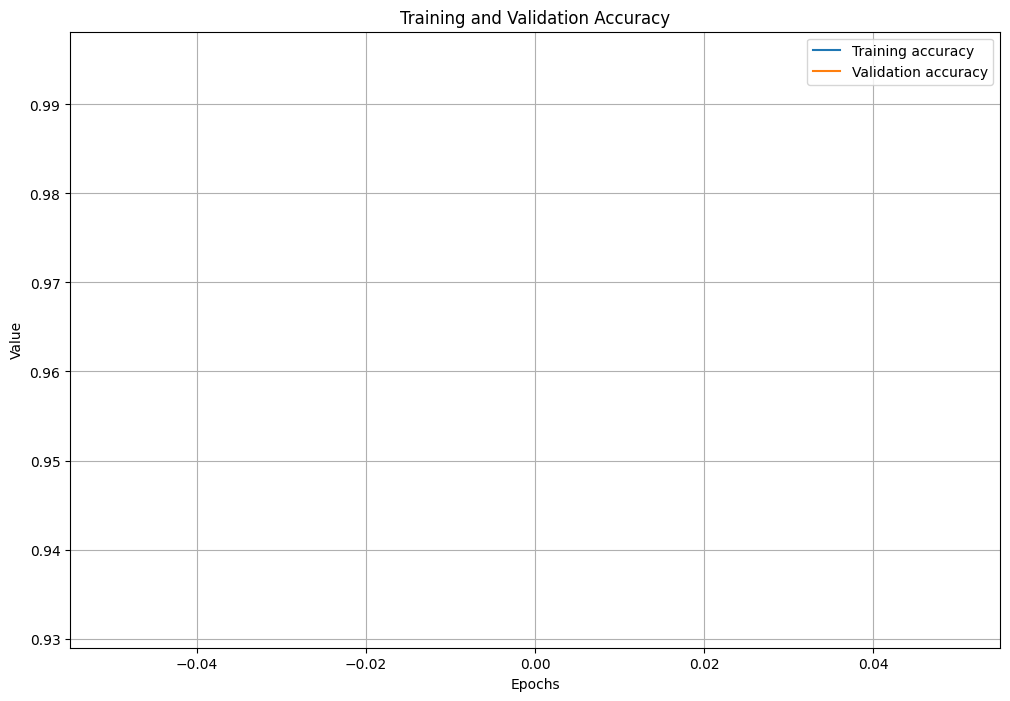

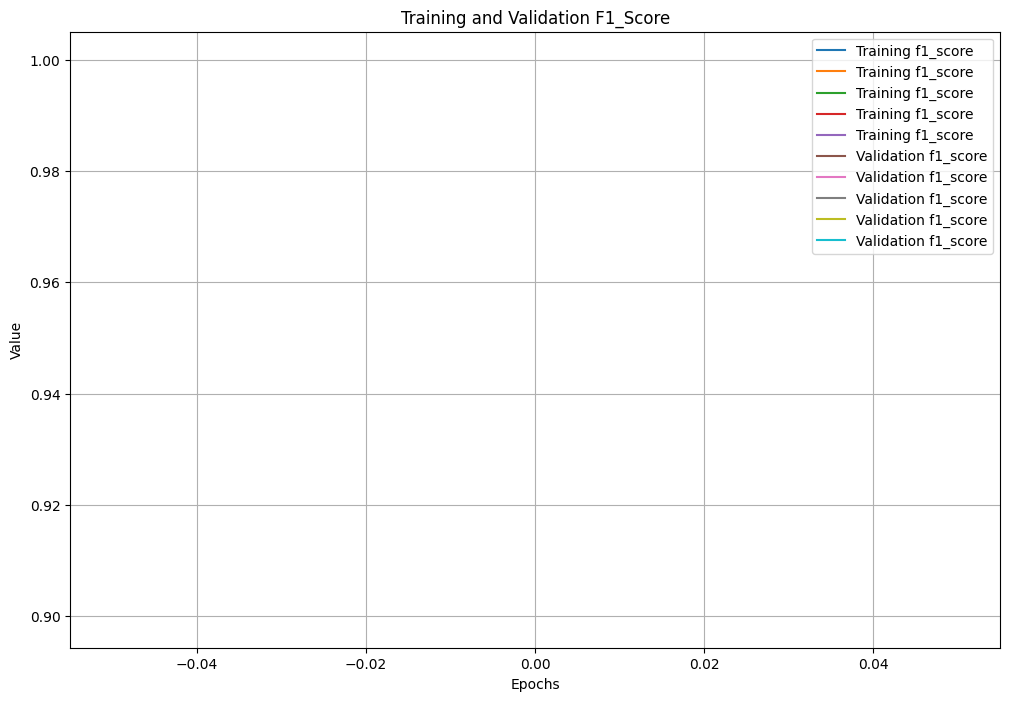

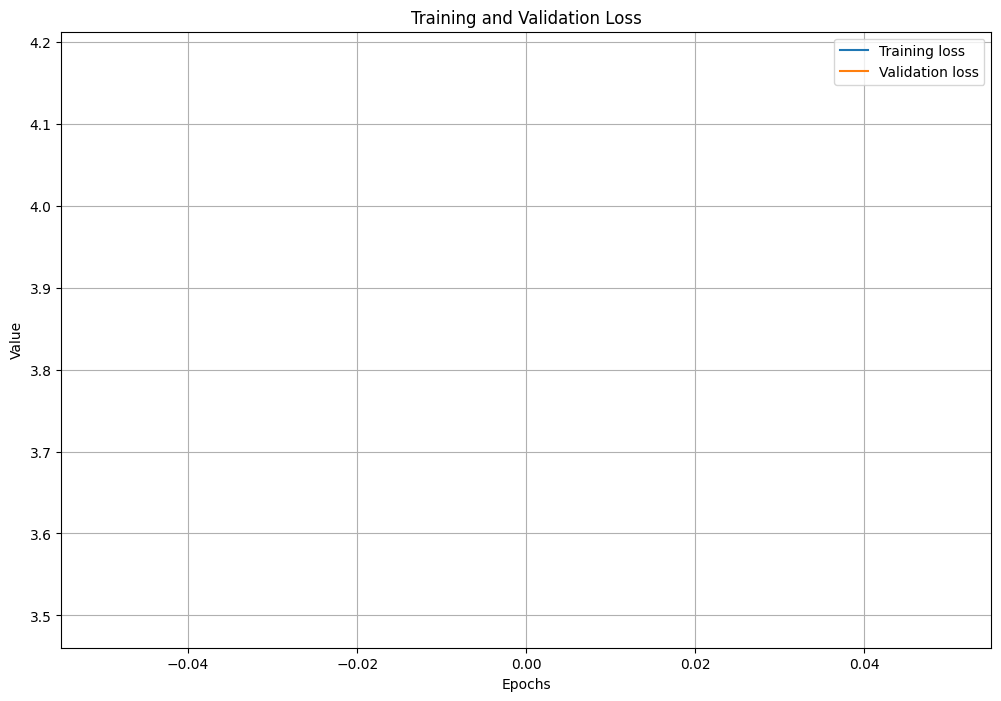

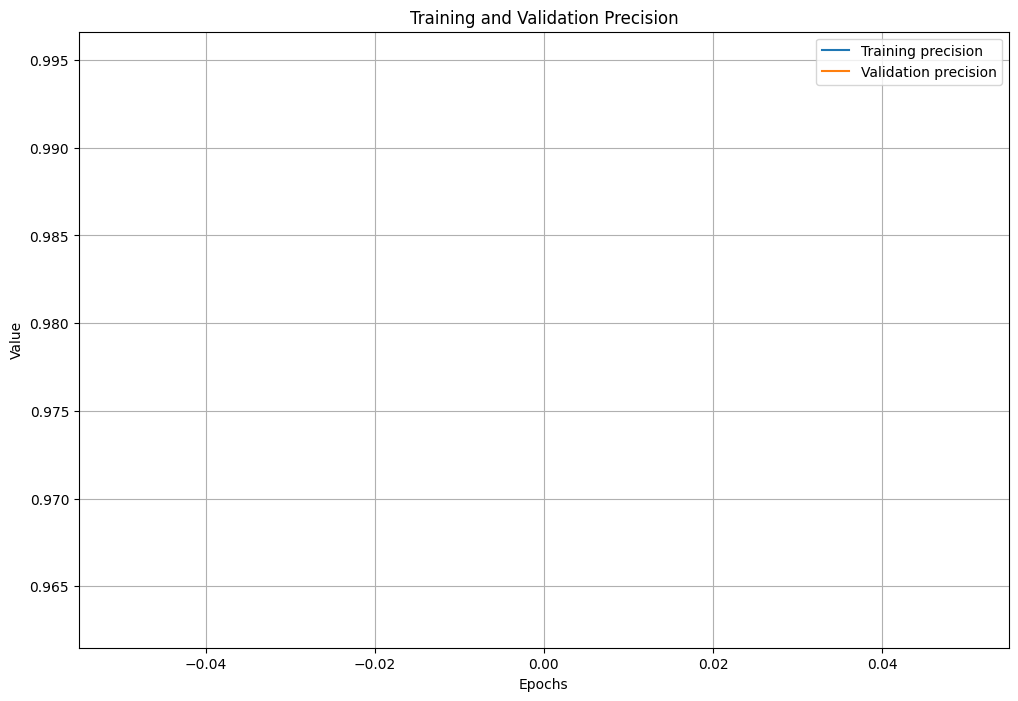

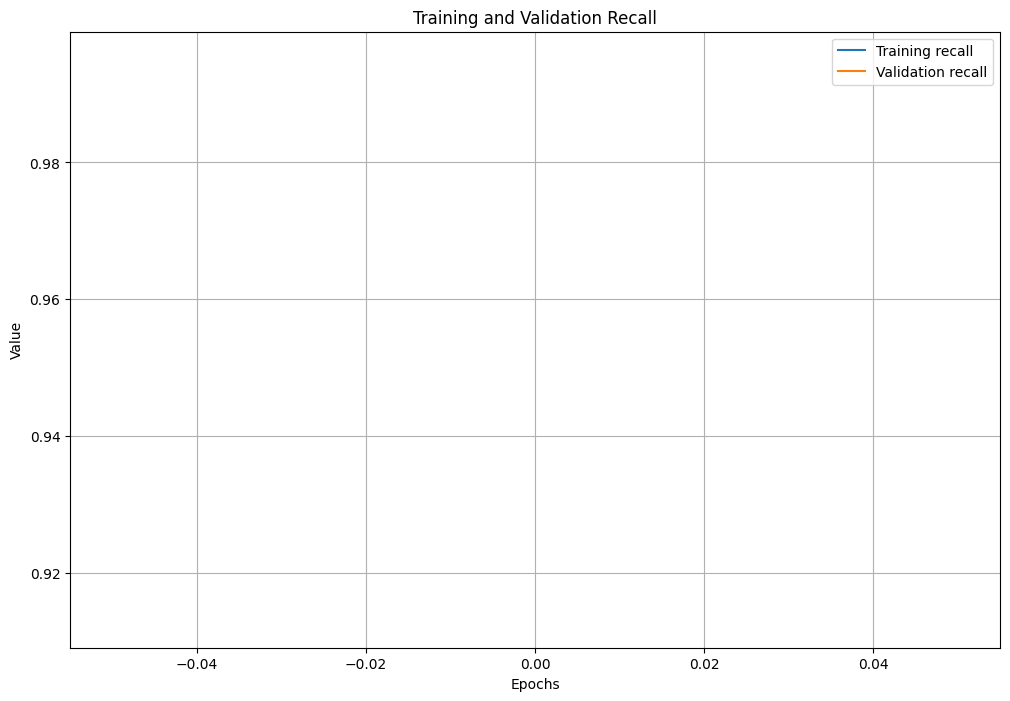

In [21]:
# visualize training metrics
figure_dicts = vis.plot_history(
    history,
    metrics=["accuracy", "f1_score", "loss", "precision", "recall"],
    separated=True,
)


for figure_dict in figure_dicts:
    dl.save_figure(
        parent_path=figure_path,
        figure_dict=figure_dict,
        format="png",
        dpi=300,
    )

Um das Modell auf unbekannte Daten zu testen, wird der Evaluationsdatensatz analog zur bereits beschriebenen Trainingsdaten-Aufbereitung (vgl. Abschnitt „Vorbereitung der Daten zur Eingabe in das neuronale Netz“) mithilfe der Funktionen `concatenate_datasets` und `split_data` strukturiert.

In [22]:
full_evaluation_dataset = ip.concatenate_datasets(evaluation_data)

test_samples_dict = ip.split_data(dataframe = full_evaluation_dataset, data_columns = [
        "vibration_1_magnitude",
        # "vibration_2_magnitude",
        # "vibration_3_magnitude",
    ],
)

Folgend wird die Funktion `check_data` auf den Evaluationsdatensatz angewendet, um die vorhandenen Klassenverteilungen zu überprüfen. Aus den One-Hot-kodierten Labels wird dabei abgeleitet, wie viele Samples pro Klasse im Evaluationsdatensatz enthalten sind. Die Ausgabe zeigt, dass auch die Evaluationsdaten eine ausgeglichene Klassenverteilung mit etwa 1669 Einträgen pro Klasse aufweisen und diese dementsprechend mit den Trainingsdaten verglichen werden können. 

In [23]:
ip.check_data(test_samples_dict)


check_data():
	Class '0 none':	1669.0 samples
	Class '1 slight':	1669.0 samples
	Class '2 moderat':	1667.0 samples
	Class '3 significant':	1669.0 samples
	Class '4 strong':	1669.0 samples


Gemäß der offiziellen Dokumentation von Keras wird mithilfe der Methode `evaluate`  im Testmodus eine Vorhersage auf dem unbekannten Testdatensatz durchgeführt. Die Methode berechnet den Loss als auch die zuvor definierten Metriken (vgl. Keras, o.D.-b). Anschließend werden diese Werte in der Ausgabe angezeigt. In diesem Projekt wird `evaluate` über eine gleichnamige Wrapper-Funktion aufgerufen und erhält die Testdaten als Eingabe. Damit lässt sich untersuchen, ob das Modell – neben den guten Resultaten auf den Trainingsdaten – auch auf neuen Datensätzen eine zuverlässige Klassifikation der Unwuchtklassen liefert. Nach Adari und Alla dient dieser Evaluationsschritt als aussagekräftiger Indikator für die Wirksamkeit des Modells (2024, S.109).

Die Ausgabe zeigt, dass das Modell auf den unbekannten Testdaten eine Vorhersagegenauigkeit (Accuracy) von 59% erreicht. Die Precision von rund 60% und der Recall von etwa 58% zeigen, dass das Netz sowohl bei der Identifizierung positiv eingestufter Fälle als auch bei der Reduktion falsch-negativer Entscheidungen noch Optimierungspotenzial aufweist. Der F1-Score zeigt, dass die Klassen *none* (mit rund 82%) und *strong* (mit rund 87%) eine deutlich höhere Vorhersagequalität aufzeigen, als die Klassen *slight* (mit rund 25%), *moderat* (mit rund 37%) und *significant* (mit rund 49%).

In [24]:
# evaluate model
evaluation = net.evaluate(model=model, test_samples_dict=test_samples_dict, batch_size=BATCH_SIZE)
display(evaluation)

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5924 - f1_score: 0.5709 - loss: 5.5827 - precision: 0.6021 - recall: 0.5858


{'accuracy': 0.5922330021858215,
 'f1_score': <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.87482256, 0.17801371, 0.3752196 , 0.51231766, 0.9004586 ],
       dtype=float32)>,
 'loss': 5.568304061889648,
 'precision': 0.6024185419082642,
 'recall': 0.5851612091064453}

### Confusion Matrix
Um die Qualität der Klassifikationsergebnisse zu prüfen wird abschließend eine Confusion Matrix erstellt. Diese baut auf den predictions der Keras `predict` Methode auf, welche Vorhersagen für die Testdaten generiert (Keras, o.D.-b). Die gleichnamige Wrapperfunktion gibt die tatsächlichen und die vorhergesagten Klassen zurück. Die Funktion `plot_confusion_matrix` erstellt eine Matrix mit den tatsächlichen Klassen in den Zeilen und den vorhergesagten Klassen in den Spalten. Auf der Diagonalen von oben links nach unten rechts sind die korrekten Vorhersagen abzulesen. Je dunkler die Farbe der Kachel ist, desto mehr Vorhersagen wurden korrekt getroffen.
Aus der abgebildeten Matrix geht hervor, dass die Klassen *none* und *strong* am zuverlässigsten klassifiziert werden. Bei der Klasse *significant* werden die meisten Vorhersagen korrekt getroffen, jedoch treten vereinzelt Fehlklassifikationen auf. Die Klassen *moderate* und *slight* weisen hingegen mehr Fehlklassifikationen als korrekte Zuordnungen auf.



261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

MODEL PREDICTIONS

[2 2 3 ... 2 1 1]
[1 1 4 ... 1 1 3]


<Figure size 1400x1400 with 0 Axes>

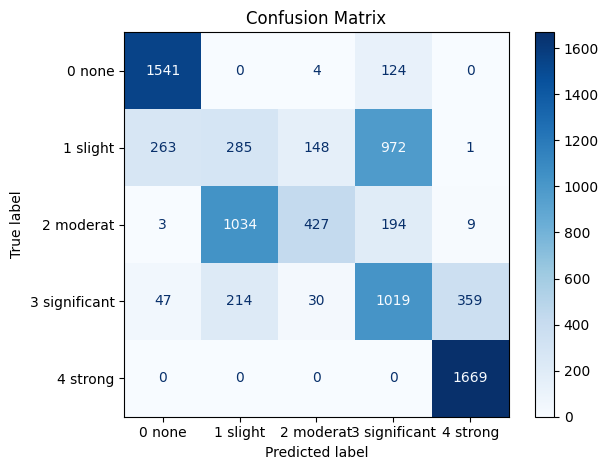

TypeError: save_model_hyperparameters() missing 1 required positional argument: 'learning_rate'

In [ ]:
# predictions by model
true_labels, predicted_labels = net.predict(model=model, test_samples_dict=test_samples_dict)

# plot confusion matrix
figure_dict = vis.plot_confusion_matrix(true_labels=true_labels,
                          predicted_labels=predicted_labels,
                          class_names=test_samples_dict["encoder"].classes_.tolist()
                          )

dl.save_figure(
    parent_path=figure_path,
    figure_dict=figure_dict,
    format="png",
    dpi=300,
)

dl.save_model_hyperparameters(
    parent_path=figure_path,
    model=model,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

#### **Quellen**
Adari, S. K. & Alla, S. (2024). Beginning Anomaly Detection Using Python-Based Deep Learning. https://doi.org/10.1007/979-8-8688-0008-5

Liu, Z.“. (2025). Deep Learning. In: Artificial Intelligence for Engineers. Springer, Cham. https://doi.org/10.1007/978-3-031-75953-6_8

Keras. (o. D.-a). Keras documentation: EarlyStopping. https://keras.io/api/callbacks/early_stopping/

Keras. (o. D.-b). Keras documentation: Model training APIs. https://keras.io/api/models/model_training_apis/

Keras. (o. D.-c). Keras documentation: The Sequential class. https://keras.io/api/models/sequential/